In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### **Loading Dataset**

In [ ]:
raw_data = pd.read_csv("DOH_Covid_dataset.csv")
raw_data.tail()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,ProvRes,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus
993143,C67472304,34.0,30 to 34,FEMALE,10/19/2022,10/20/2022,10/22/2022,NaN,NaN,NaN,...,CAVITE,BACOOR CITY,PH042103000,MOLINO V,PH042103048,MILD,NO,NaN,NO,NaN
993144,C45614651,46.0,45 to 49,FEMALE,10/19/2022,10/20/2022,10/22/2022,NaN,NaN,NaN,...,MISAMIS ORIENTAL,CAGAYAN DE ORO CITY (CAPITAL),PH104305000,BARANGAY 1 (POB.),PH104305073,MILD,NO,10/19/2022,NO,NaN
993145,C53134948,35.0,35 to 39,FEMALE,10/20/2022,10/20/2022,10/22/2022,NaN,NaN,NaN,...,NCR,CITY OF MANDALUYONG,PH137401000,HIGHWAY HILLS,PH137401013,MILD,NO,10/17/2022,NO,NaN
993146,C14902216,25.0,25 to 29,FEMALE,10/18/2022,10/19/2022,10/22/2022,NaN,NaN,NaN,...,LA UNION,NaN,NaN,NaN,NaN,MILD,NO,NaN,NO,NaN
993147,C58785111,29.0,25 to 29,MALE,10/20/2022,10/20/2022,10/22/2022,NaN,NaN,NaN,...,NCR,QUEZON CITY,PH137404000,NOVALICHES PROPER,PH137404070,MILD,NO,NaN,NaN,Age or Birthdate is Invalid


## **Data Cleaning**

#### Checking for null values

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993148 entries, 0 to 993147
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CaseCode           993147 non-null  object 
 1   Age                987424 non-null  float64
 2   AgeGroup           987424 non-null  object 
 3   Sex                993147 non-null  object 
 4   DateSpecimen       802571 non-null  object 
 5   DateResultRelease  803885 non-null  object 
 6   DateRepConf        993148 non-null  object 
 7   DateDied           5900 non-null    object 
 8   DateRecover        167924 non-null  object 
 9   RemovalType        969435 non-null  object 
 10  Admitted           958496 non-null  object 
 11  RegionRes          992617 non-null  object 
 12  ProvRes            980905 non-null  object 
 13  CityMunRes         969829 non-null  object 
 14  CityMuniPSGC       969981 non-null  object 
 15  BarangayRes        951538 non-null  object 
 16  Ba

In [ ]:
raw_data["RemovalType"].value_counts()

RECOVERED    963470
DIED           5965
Name: RemovalType, dtype: int64

In [ ]:
raw_data["RegionRes"].value_counts()

NCR                               323461
Region IV-A: CALABARZON           186043
Region III: Central Luzon          98128
Region VI: Western Visayas         57482
Region VII: Central Visayas        49517
Region XI: Davao Region            43798
Region I: Ilocos Region            36280
CAR                                32818
Region II: Cagayan Valley          31187
Region X: Northern Mindanao        25053
Region XII: SOCCSKSARGEN           21427
Region V: Bicol Region             18499
Region IX: Zamboanga Peninsula     15370
CARAGA                             14169
Region VIII: Eastern Visayas       12856
ROF                                 9967
Region IV-B: MIMAROPA               9187
BARMM                               7375
Name: RegionRes, dtype: int64

### **Creating new dataset for Data Exploration**

In [ ]:
raw_data2 = raw_data[['DateRepConf','Age','RegionRes','RemovalType']]
raw_data2.head()

,DateRepConf,Age,RegionRes,RemovalType
0,1/11/2022,31.0,Region IV-A: CALABARZON,RECOVERED
1,1/11/2022,21.0,NCR,RECOVERED
2,1/11/2022,32.0,NCR,RECOVERED
3,1/11/2022,8.0,NCR,RECOVERED
4,1/11/2022,31.0,NCR,RECOVERED


#### Converting the unique inputs in the categorical column "RemovalType" into separate columns using pd.Dummies

In [ ]:
dummies_RemovalType = pd.get_dummies(raw_data2.RemovalType)

In [ ]:
merge_data2 = pd.concat([raw_data2,dummies_RemovalType],axis='columns')
merge_data2['RemovalType'].isnull().sum()

23713

In [ ]:
merge_data2.head()

,DateRepConf,Age,RegionRes,RemovalType,DIED,RECOVERED
0,1/11/2022,31.0,Region IV-A: CALABARZON,RECOVERED,0,1
1,1/11/2022,21.0,NCR,RECOVERED,0,1
2,1/11/2022,32.0,NCR,RECOVERED,0,1
3,1/11/2022,8.0,NCR,RECOVERED,0,1
4,1/11/2022,31.0,NCR,RECOVERED,0,1


#### Creating a new column named "Active" for patients that have been tagged by DOH with the Covid-19 symptom.

In [ ]:
merge_data2['active'] = np.where((merge_data2.RemovalType != 'RECOVERED')&(merge_data2.RemovalType != 'DIED'),1,0)
merge_data2.tail()

,DateRepConf,Age,RegionRes,RemovalType,DIED,RECOVERED,active
993143,10/22/2022,34.0,Region IV-A: CALABARZON,NaN,0,0,1
993144,10/22/2022,46.0,Region X: Northern Mindanao,NaN,0,0,1
993145,10/22/2022,35.0,NCR,NaN,0,0,1
993146,10/22/2022,25.0,Region I: Ilocos Region,NaN,0,0,1
993147,10/22/2022,29.0,NCR,NaN,0,0,1


In [ ]:
merge_data2['active'] = np.where((merge_data2.RemovalType != 'RECOVERED')&(merge_data2.RemovalType != 'DIED'),1,0)
merge_data2.tail()

,DateRepConf,Age,RegionRes,RemovalType,DIED,RECOVERED,active
993143,10/22/2022,34.0,Region IV-A: CALABARZON,NaN,0,0,1
993144,10/22/2022,46.0,Region X: Northern Mindanao,NaN,0,0,1
993145,10/22/2022,35.0,NCR,NaN,0,0,1
993146,10/22/2022,25.0,Region I: Ilocos Region,NaN,0,0,1
993147,10/22/2022,29.0,NCR,NaN,0,0,1


#### Creating a new column named "Confirmed" for total number of patients that have been tagged by DOH with the Covid-19 symptom.

In [ ]:
merge_data2['Confirmed'] = merge_data2['DIED'] + merge_data2['RECOVERED'] + merge_data2['active']
merge_data2.head()

,DateRepConf,Age,RegionRes,RemovalType,DIED,RECOVERED,active,Confirmed
0,1/11/2022,31.0,Region IV-A: CALABARZON,RECOVERED,0,1,0,1
1,1/11/2022,21.0,NCR,RECOVERED,0,1,0,1
2,1/11/2022,32.0,NCR,RECOVERED,0,1,0,1
3,1/11/2022,8.0,NCR,RECOVERED,0,1,0,1
4,1/11/2022,31.0,NCR,RECOVERED,0,1,0,1


#### Renaming columns and Dropping "RemovalType"

In [ ]:
merge_data2.rename(columns={'DIED':'Died','RECOVERED':'Recovered','active':'Active','RegionRes':'Region','DateRepConf':'Date'},inplace=True)
merge_data2.tail()

,Date,Age,Region,RemovalType,Died,Recovered,Active,Confirmed
993143,10/22/2022,34.0,Region IV-A: CALABARZON,NaN,0,0,1,1
993144,10/22/2022,46.0,Region X: Northern Mindanao,NaN,0,0,1,1
993145,10/22/2022,35.0,NCR,NaN,0,0,1,1
993146,10/22/2022,25.0,Region I: Ilocos Region,NaN,0,0,1,1
993147,10/22/2022,29.0,NCR,NaN,0,0,1,1


In [ ]:
final_data = merge_data2.drop(['RemovalType'],axis='columns')
final_data.head()

,Date,Age,Region,Died,Recovered,Active,Confirmed
0,1/11/2022,31.0,Region IV-A: CALABARZON,0,1,0,1
1,1/11/2022,21.0,NCR,0,1,0,1
2,1/11/2022,32.0,NCR,0,1,0,1
3,1/11/2022,8.0,NCR,0,1,0,1
4,1/11/2022,31.0,NCR,0,1,0,1


### **Data Exploration**

#### Creating a pivot table to determine the total number of Covid-19 cases in each region

In [ ]:
Regiondata = pd.pivot_table(final_data,values=['Confirmed','Recovered','Died'], index = 'Region',aggfunc=sum)
Regiondata['Recovery Rate'] = Regiondata['Recovered']*100/Regiondata['Confirmed']
Regiondata['Mortality Rate'] = Regiondata['Died']*100/Regiondata['Confirmed']
Regiondata = Regiondata.sort_values(by ='Confirmed', ascending = False)
Regiondata

,Confirmed,Died,Recovered,Recovery Rate,Mortality Rate
Region,,,,,
NCR,323461,952.0,315176.0,97.438640,0.294317
Region IV-A: CALABARZON,186043,515.0,181412.0,97.510791,0.276818
Region III: Central Luzon,98128,941.0,94430.0,96.231453,0.958952
Region VI: Western Visayas,57482,572.0,55086.0,95.831739,0.995094
Region VII: Central Visayas,49517,625.0,47725.0,96.381041,1.262193
Region XI: Davao Region,43798,412.0,41902.0,95.671035,0.940682
Region I: Ilocos Region,36280,363.0,35138.0,96.852260,1.000551
CAR,32818,306.0,32125.0,97.888354,0.932415
Region II: Cagayan Valley,31187,413.0,30203.0,96.844839,1.324270


#### Plotting the Top 10 Regions with Highest Covid-19 Active cases

In [ ]:
top_10_active = final_data.groupby(['Region'],as_index = False)['Active'].sum()
top_10_active = top_10_active.sort_values(by='Active',ascending=False)

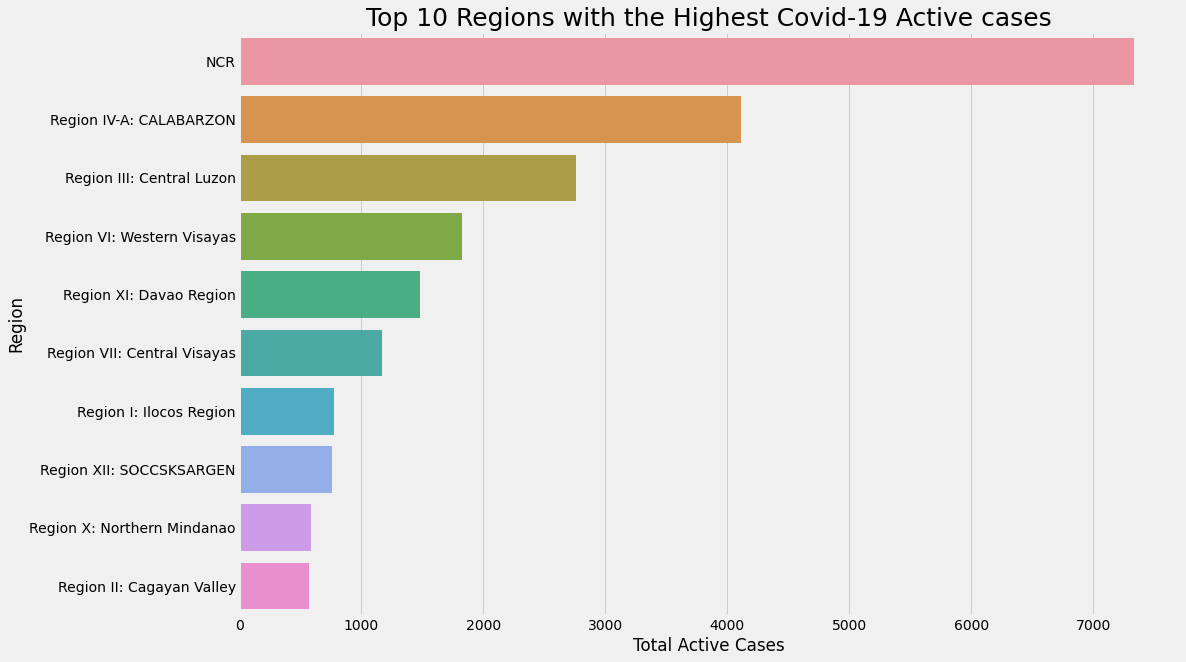

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.title("Top 10 Regions with the Highest Covid-19 Active cases",size=25)
ax = sns.barplot(data= top_10_active.iloc[:10], y="Region", x="Active")
plt.xlabel('Total Active Cases')
plt.ylabel('Region')
plt.show()

In [ ]:
final_data2 = final_data.copy()
final_data2.head()
final_data2['Date'] = pd.to_datetime(final_data2['Date'])
final_data2.head()

,Date,Age,Region,Died,Recovered,Active,Confirmed
0,2022-01-11,31.0,Region IV-A: CALABARZON,0,1,0,1
1,2022-01-11,21.0,NCR,0,1,0,1
2,2022-01-11,32.0,NCR,0,1,0,1
3,2022-01-11,8.0,NCR,0,1,0,1
4,2022-01-11,31.0,NCR,0,1,0,1


#### Determining the Top 5 Region with Highest Mortality Rate

In [ ]:
try1 = final_data2[final_data2['Region'].isin(['NCR','Region IV-A: CALABARZON','Region III: Central Luzon','Region VI: Western Visayas','Region XI: Davao Region'])]
try2 = pd.pivot_table(try1,values=['Confirmed','Recovered','Died'], index = 'Region',aggfunc=sum)
try2['Recovery Rate'] = try2['Recovered']*100/try2['Confirmed']
try2['Mortality Rate'] = try2['Died']*100/try2['Confirmed']
try2 = try2.sort_values(by ='Mortality Rate', ascending = False)
try2

,Confirmed,Died,Recovered,Recovery Rate,Mortality Rate
Region,,,,,
Region VI: Western Visayas,57482,572.0,55086.0,95.831739,0.995094
Region III: Central Luzon,98128,941.0,94430.0,96.231453,0.958952
Region XI: Davao Region,43798,412.0,41902.0,95.671035,0.940682
NCR,323461,952.0,315176.0,97.438640,0.294317
Region IV-A: CALABARZON,186043,515.0,181412.0,97.510791,0.276818


### **Creating new dataset for the Time Series Model**

In [ ]:
Date = final_data["Date"].unique().tolist()
Died_cases = []
Active_cases = []
Recovered_cases = []
Confirmed_cases = []

for i in Date:
    Died_cases.append((final_data.loc[final_data["Date"] == i, "Died"]).sum())
    Active_cases.append((final_data.loc[final_data["Date"] == i, "Active"]).sum())
    Recovered_cases.append((final_data.loc[final_data["Date"] == i, "Recovered"]).sum())
    Confirmed_cases.append((final_data.loc[final_data["Date"] == i, "Confirmed"]).sum())

aggregated_data = pd.DataFrame(list(zip(Date, Confirmed_cases, Active_cases, Recovered_cases, Died_cases)), 
                               columns = ["Date", "Daily_Confirmed", "Daily_Active", 
                                          "Daily_Recovered", "Daily_Died"])
print(aggregated_data.head())

        Date  Daily_Confirmed  Daily_Active  Daily_Recovered  Daily_Died
0  1/11/2022            23980             0            23929          51
1  1/12/2022            32087             0            31992          95
2  1/13/2022            33738             0            33637         101
3  1/14/2022            37054             0            36950         104
4  1/15/2022            38847             0            38740         107


In [ ]:
df = aggregated_data.copy()
df.head()

,Date,Daily_Confirmed,Daily_Active,Daily_Recovered,Daily_Died
0,1/11/2022,23980,0,23929,51
1,1/12/2022,32087,0,31992,95
2,1/13/2022,33738,0,33637,101
3,1/14/2022,37054,0,36950,104
4,1/15/2022,38847,0,38740,107


### **Data Cleaning**

#### Converting the date column into Datetime 

In [ ]:
df['Date'] = pd.to_datetime(aggregated_data['Date'])
df.head()

,Date,Daily_Confirmed,Daily_Active,Daily_Recovered,Daily_Died
0,2022-01-11,23980,0,23929,51
1,2022-01-12,32087,0,31992,95
2,2022-01-13,33738,0,33637,101
3,2022-01-14,37054,0,36950,104
4,2022-01-15,38847,0,38740,107


### **Data Exploration**

In [ ]:
fig = px.bar(df, x='Date', y='Daily_Confirmed')
fig.show()

In [ ]:
fig = px.bar(df, x='Date', y='Daily_Died')
fig.show()

In [ ]:
fig = px.bar(df, x='Date', y='Daily_Recovered')
fig.show()

In [ ]:
cases = df["Daily_Confirmed"].sum()
deceased = df["Daily_Died"].sum()

labels = ["Confirmed", "Deceased"]
values = [cases, deceased]

fig = px.pie(aggregated_data, values=values, 
             names=labels, 
             title='Daily Confirmed Cases vs Daily Deaths', hole=0.5)
fig.show()

In [ ]:
df_new = aggregated_data[['Date','Daily_Confirmed']].copy()
df_new = df_new.set_index('Date')
df_new.index = pd.to_datetime(df_new.index)

### **Creating the Features for the Time Series Model**

#### Adding "Day of week", "Month", and "Day of month" as our initial features

In [ ]:
def create_features(df_new):
    df_new = df_new.copy()
    df_new['dayofweek'] = df_new.index.dayofweek
    df_new['month'] = df_new.index.month
    df_new['dayofmonth'] = df_new.index.day
    return df_new

df_new = create_features(df_new)

In [ ]:
df_new.head()

,Daily_Confirmed,dayofweek,month,dayofmonth
Date,,,,
2022-01-11,23980,1,1,11
2022-01-12,32087,2,1,12
2022-01-13,33738,3,1,13
2022-01-14,37054,4,1,14
2022-01-15,38847,5,1,15


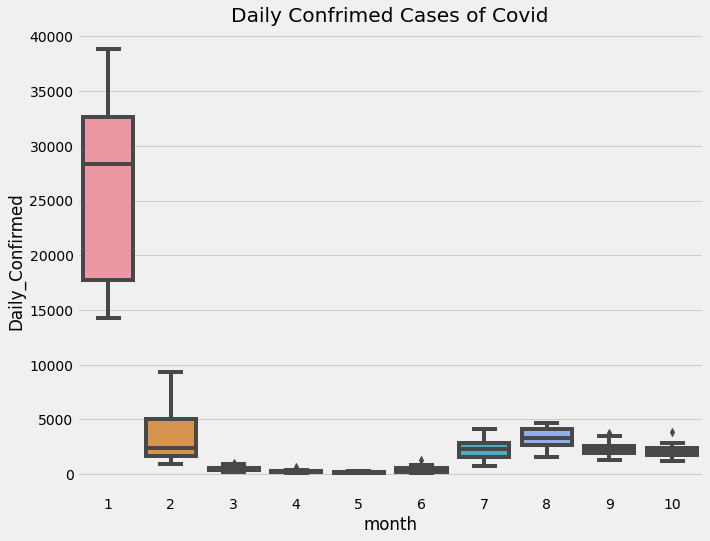

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_new, x='month', y='Daily_Confirmed')
ax.set_title('Daily Confrimed Cases of Covid')
plt.show()

#### Creating Lag Features as an additional features for our model

In [ ]:
def add_lags(df_new):
    target_map = df_new['Daily_Confirmed'].to_dict()
    df_new['lag1'] = (df_new.index - pd.Timedelta('30 days')).map(target_map)
    df_new['lag2'] = (df_new.index - pd.Timedelta('60 days')).map(target_map)
    df_new['lag3'] = (df_new.index - pd.Timedelta('90 days')).map(target_map)
    return df_new

In [ ]:
df_new = add_lags(df_new)
df_new.tail()

,Daily_Confirmed,dayofweek,month,dayofmonth,lag1,lag2,lag3
Date,,,,,,,
2022-10-18,1194,1,10,18,2362.0,3725.0,1932.0
2022-10-19,1377,2,10,19,3111.0,3687.0,2818.0
2022-10-20,2223,3,10,20,1594.0,3605.0,3372.0
2022-10-21,1983,4,10,21,1883.0,2719.0,3580.0
2022-10-22,1702,5,10,22,2688.0,1711.0,3533.0


### **Splitting our data into Train set and Test set**

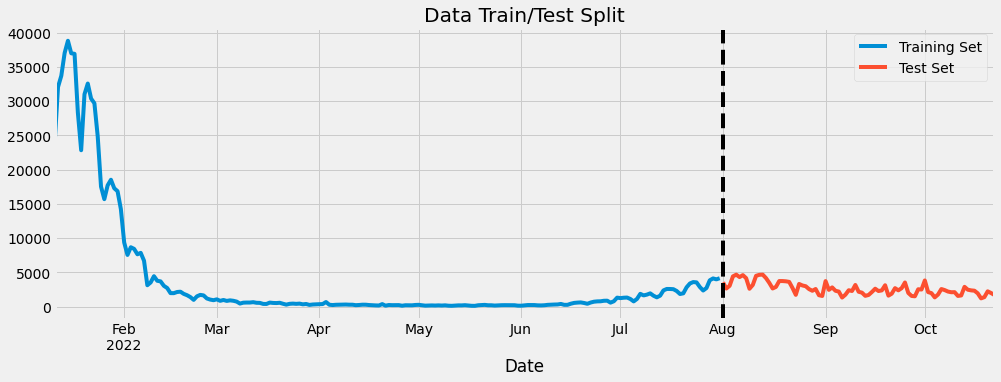

In [ ]:
train = df_new.loc[df_new.index < '08/01/2022']
test = df_new.loc[df_new.index >= '08/01/2022']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='Daily_Confirmed', label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax,y='Daily_Confirmed', label='Test Set')
ax.axvline('08/01/2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'month', 'dayofmonth','lag1', 'lag2', 'lag3']
TARGET = 'Daily_Confirmed'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### **Creating the Time Series model using XGBRegressor** 

In [ ]:
# Creating the Model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=900,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[16:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9071.98	validation_1-rmse:2773.23
[100]	validation_0-rmse:3798.73	validation_1-rmse:1879.03
[200]	validation_0-rmse:1738.83	validation_1-rmse:1437.41
[300]	validation_0-rmse:899.838	validation_1-rmse:1278.73
[400]	validation_0-rmse:558.906	validation_1-rmse:1191.22
[500]	validation_0-rmse:417.029	validation_1-rmse:1157.89
[600]	validation_0-rmse:347.423	validation_1-rmse:1154.62
[700]	validation_0-rmse:299.223	validation_1-rmse:1149.29
[800]	validation_0-rmse:275.399	validation_1-rmse:1144.16
[899]	validation_0-rmse:262.326	validation_1-rmse:1141.49


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=900)

### **Model Validation**

#### Plotting the Original Data against the Predicted Data from the model



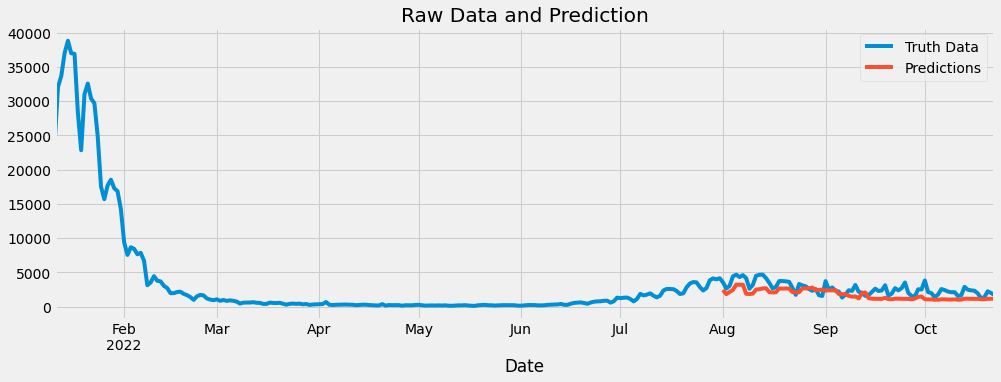

In [ ]:
test['prediction'] = reg.predict(X_test)
df_new = df_new.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_new[['Daily_Confirmed']].plot(figsize=(15, 5))
df_new['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

#### Getting the Root Mean Square Error of the model

In [ ]:
score = np.sqrt(mean_squared_error(test['Daily_Confirmed'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1141.49


### **Model Prediction on new data**

#### Retraining our Model using the entire data

In [ ]:
#Predicting 1-Month of Confirmed Covid-19 Cases
# Retrain on all data
df_newF = create_features(df_new)
FEATURES = ['dayofweek', 'month', 'dayofmonth','lag1', 'lag2', 'lag3']
TARGET = 'Daily_Confirmed'

X_all = df_newF[FEATURES]
y_all = df_newF[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=900,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7780.74
[100]	validation_0-rmse:3282.59
[200]	validation_0-rmse:1542.01
[300]	validation_0-rmse:845.782
[400]	validation_0-rmse:574.567
[500]	validation_0-rmse:462.474
[600]	validation_0-rmse:402.572
[700]	validation_0-rmse:362.333
[800]	validation_0-rmse:336.908
[899]	validation_0-rmse:318.196


XGBRegressor(learning_rate=0.01, n_estimators=900)

In [ ]:
df_newF = df_newF[['Daily_Confirmed', 'dayofweek', 'month', 'dayofmonth','lag1', 'lag2', 'lag3', 'prediction']]

#### Creating the new dates for the forecasting

In [ ]:
# Create future dataframe
futureF = pd.date_range('2022-10-22','2022-12-31')
future_dfF = pd.DataFrame(index=futureF)
future_dfF.index = pd.to_datetime(future_dfF.index)
future_dfF['isFuture'] = True
df_newF['isFuture'] = False

In [ ]:
df_new2_and_future2 = pd.concat([df_newF, future_dfF])
df_new2_and_future2 = create_features(df_new2_and_future2)
df_new2_and_future2 = add_lags(df_new2_and_future2)
df_new2_and_future2.tail()

,Daily_Confirmed,dayofweek,month,dayofmonth,lag1,lag2,lag3,prediction,isFuture
2022-12-27,NaN,1,12,27,NaN,NaN,1499.0,NaN,True
2022-12-28,NaN,2,12,28,NaN,NaN,2529.0,NaN,True
2022-12-29,NaN,3,12,29,NaN,NaN,2488.0,NaN,True
2022-12-30,NaN,4,12,30,NaN,NaN,3814.0,NaN,True
2022-12-31,NaN,5,12,31,NaN,NaN,2112.0,NaN,True


In [ ]:
future_w_features = df_new2_and_future2.query('isFuture').copy()
future_w_features.head()

,Daily_Confirmed,dayofweek,month,dayofmonth,lag1,lag2,lag3,prediction,isFuture
2022-10-22,NaN,5,10,22,2688.0,1711.0,3533.0,NaN,True
2022-10-23,NaN,6,10,23,2369.0,3301.0,2857.0,NaN,True
2022-10-24,NaN,0,10,24,2690.0,3084.0,2347.0,NaN,True
2022-10-25,NaN,1,10,25,3517.0,2969.0,2707.0,NaN,True
2022-10-26,NaN,2,10,26,1992.0,2551.0,3839.0,NaN,True


#### Using the Model on our new data

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [ ]:
#Forecasting Result
future_w_features['pred']

2022-10-22    2244.004883
2022-10-23    2238.612793
2022-10-24    2041.671387
2022-10-25    1610.310669
2022-10-26    1736.679443
                 ...     
2022-12-27    2936.340820
2022-12-28    2940.451416
2022-12-29    3626.510254
2022-12-30    3609.841309
2022-12-31    3519.173340
Name: pred, Length: 71, dtype: float32

### **Plotting our Forcasted Result**

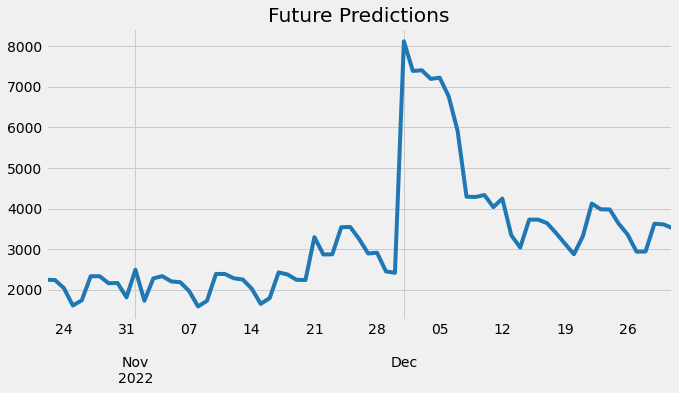

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[0],
                               title='Future Predictions')
plt.show()

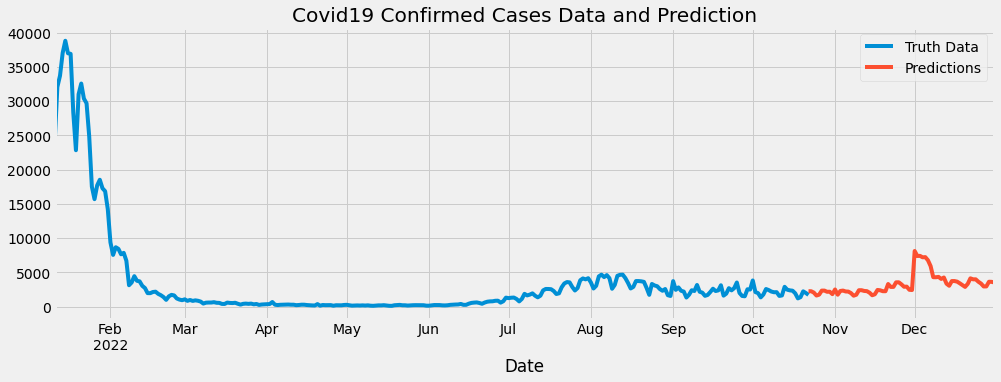

In [ ]:
ax = df_new[['Daily_Confirmed']].plot(figsize=(15, 5))
future_w_features['pred'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Covid19 Confirmed Cases Data and Prediction')
plt.show()